In [1]:
# ================================
# 1. Data Retrieval and Preparation
# ================================

import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
prices = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                     interval=Interval.in_1_hour, n_bars=2000)

# Ensure the 'close' column is in numeric format
prices['close'] = pd.to_numeric(prices['close'], errors='coerce')

# Drop any rows with NaN values in 'close'
prices.dropna(subset=['close'], inplace=True)

# Reset index if necessary
prices.reset_index(drop=True, inplace=True)

# Verify total data points after cleaning
total_data_points = prices.shape[0]
print(f"Total data points after cleaning: {total_data_points}")

# ================================
# 2. Hyperparameter Optimization
# ================================

# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Define optimization parameters
fixed_train_size = 1200       # Fixed training size
fixed_seasonal = False        # Fixed seasonality
forecast_elements = 24        # Number of data points to forecast (24 hours)
shift_step = 10               # Shift each run by 10 data points
num_runs = 30                 # Number of rolling window iterations

# Define ranges for Savitzky-Golay filter parameters
window_lengths = list(range(9, 40, 2))   # [9, 11, 13, ..., 39]
polyorders = [0, 1, 2]                    # [0, 1, 2]

# Initialize a list to store results
results = []

# Loop through each combination of window_length and polyorder
for window_length in window_lengths:
    for polyorder in polyorders:
        # Ensure that window_length is greater than polyorder
        if window_length <= polyorder:
            print(f"\nSkipping window_length={window_length}, polyorder={polyorder} as window_length <= polyorder.")
            continue
        
        # Initialize a list to store RMSE for each run
        rmse_list = []
        
        print(f"\nOptimizing for window_length={window_length}, polyorder={polyorder}...")
        
        for run in range(num_runs):
            # Define shift for rolling window
            shift = run * shift_step
            
            # Calculate indices for slicing using positive indices
            start_idx = total_data_points - (fixed_train_size + forecast_elements + shift)
            end_train_idx = total_data_points - (forecast_elements + shift)
            test_start_idx = end_train_idx
            test_end_idx = end_train_idx + forecast_elements
            
            # Ensure indices are within bounds
            if start_idx < 0 or test_end_idx > total_data_points:
                print(f"  Skipping run {run} due to insufficient data (shift={shift}).")
                continue
            
            # Slice the data for training and testing
            train_prices = prices.iloc[start_idx:end_train_idx]
            test_prices = prices.iloc[test_start_idx:test_end_idx]
            
            # Verify that slicing has the correct number of data points
            if len(train_prices) != fixed_train_size or len(test_prices) != forecast_elements:
                print(f"  Run {run} failed: Incorrect slice sizes (train_size={len(train_prices)}, test_size={len(test_prices)}).")
                rmse_list.append(np.nan)
                continue
            
            # Extract the trend component using Savitzky-Golay filter on training data
            try:
                trend_train = savgol_filter(train_prices['close'], window_length=window_length, polyorder=polyorder)
            except ValueError as e:
                print(f"  Run {run} failed during Savitzky-Golay filter on training data: {e}")
                rmse_list.append(np.nan)
                continue
            
            # Fit Auto-ARIMA model
            try:
                smodel = pm.auto_arima(
                    trend_train,
                    start_p=1, start_q=1,
                    max_p=3, max_q=3,
                    seasonal=fixed_seasonal,
                    m=24 if fixed_seasonal else 1,    # Set m=24 for daily seasonality if seasonal=True
                    d=None,
                    D=1 if fixed_seasonal else 0,
                    trace=False,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True
                )
                
                # Forecast the next 24 data points (trend_forecast)
                forecast_trend = smodel.predict(n_periods=forecast_elements)
            except Exception as e:
                print(f"  Run {run} failed during Auto-ARIMA fitting or forecasting: {e}")
                rmse_list.append(np.nan)
                continue
            
            # Extract the actual trend for the test data
            try:
                # Concatenate train and test close prices
                combined_prices = pd.concat([train_prices['close'], test_prices['close']])
                
                # Apply the Savitzky-Golay filter to the combined data
                trend_total = savgol_filter(combined_prices, window_length=window_length, polyorder=polyorder)
                
                # Extract the trend for the test data (last 24 elements)
                trend_test = trend_total[-forecast_elements:]
            except ValueError as e:
                print(f"  Run {run} failed during Savitzky-Golay filter on combined data: {e}")
                rmse_list.append(np.nan)
                continue
            
            # Calculate RMSE between forecasted trend and actual test trend
            rmse = calculate_rmse(trend_test, forecast_trend)
            rmse_list.append(rmse)
        
        # Calculate average RMSE across all runs, ignoring NaN values
        if rmse_list:
            avg_rmse = np.nanmean(rmse_list)
        else:
            avg_rmse = np.nan
        
        # Store the results
        results.append({
            'window_length': window_length,
            'polyorder': polyorder,
            'avg_rmse': avg_rmse
        })
        
        print(f"  Completed: window_length={window_length}, polyorder={polyorder}, avg_rmse={avg_rmse:.4f}")


error while signin
you are using nologin method, data you access may be limited


Total data points after cleaning: 2000

Optimizing for window_length=9, polyorder=0...
  Completed: window_length=9, polyorder=0, avg_rmse=10.8326

Optimizing for window_length=9, polyorder=1...
  Completed: window_length=9, polyorder=1, avg_rmse=12.4252

Optimizing for window_length=9, polyorder=2...
  Completed: window_length=9, polyorder=2, avg_rmse=11.4650

Optimizing for window_length=11, polyorder=0...
  Completed: window_length=11, polyorder=0, avg_rmse=10.6160

Optimizing for window_length=11, polyorder=1...
  Completed: window_length=11, polyorder=1, avg_rmse=12.2896

Optimizing for window_length=11, polyorder=2...
  Completed: window_length=11, polyorder=2, avg_rmse=11.7834

Optimizing for window_length=13, polyorder=0...
  Completed: window_length=13, polyorder=0, avg_rmse=10.8515

Optimizing for window_length=13, polyorder=1...
  Completed: window_length=13, polyorder=1, avg_rmse=11.8098

Optimizing for window_length=13, polyorder=2...
  Completed: window_length=13, polyord

In [2]:
results

[{'window_length': 9, 'polyorder': 0, 'avg_rmse': 10.832625602779897},
 {'window_length': 9, 'polyorder': 1, 'avg_rmse': 12.425241230883897},
 {'window_length': 9, 'polyorder': 2, 'avg_rmse': 11.46502455925787},
 {'window_length': 11, 'polyorder': 0, 'avg_rmse': 10.615950076167236},
 {'window_length': 11, 'polyorder': 1, 'avg_rmse': 12.289646891431863},
 {'window_length': 11, 'polyorder': 2, 'avg_rmse': 11.783424879260755},
 {'window_length': 13, 'polyorder': 0, 'avg_rmse': 10.851506564825462},
 {'window_length': 13, 'polyorder': 1, 'avg_rmse': 11.809758260779764},
 {'window_length': 13, 'polyorder': 2, 'avg_rmse': 11.685393076216283},
 {'window_length': 15, 'polyorder': 0, 'avg_rmse': 11.054352749382467},
 {'window_length': 15, 'polyorder': 1, 'avg_rmse': 11.386858711907623},
 {'window_length': 15, 'polyorder': 2, 'avg_rmse': 13.391669311567425},
 {'window_length': 17, 'polyorder': 0, 'avg_rmse': 11.018715100777149},
 {'window_length': 17, 'polyorder': 1, 'avg_rmse': 10.98386005928015

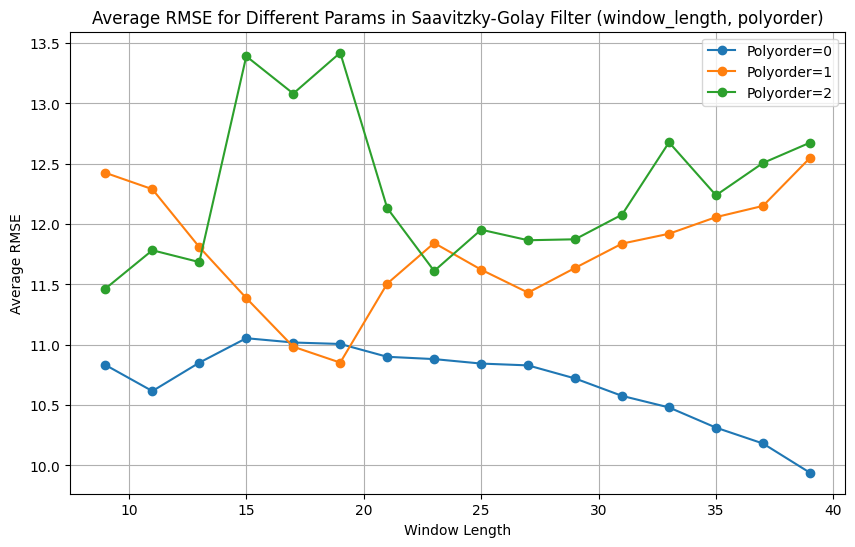

In [5]:
# Data from the new results
data = results
# Extract data
window_lengths = [entry['window_length'] for entry in data]
polyorder_0 = [entry['avg_rmse'] for entry in data if entry['polyorder'] == 0]
polyorder_1 = [entry['avg_rmse'] for entry in data if entry['polyorder'] == 1]
polyorder_2 = [entry['avg_rmse'] for entry in data if entry['polyorder'] == 2]

# Window lengths corresponding to each polyorder
window_lengths_polyorder_0 = [entry['window_length'] for entry in data if entry['polyorder'] == 0]
window_lengths_polyorder_1 = [entry['window_length'] for entry in data if entry['polyorder'] == 1]
window_lengths_polyorder_2 = [entry['window_length'] for entry in data if entry['polyorder'] == 2]

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(window_lengths_polyorder_0, polyorder_0, label="Polyorder=0", marker='o')
plt.plot(window_lengths_polyorder_1, polyorder_1, label="Polyorder=1", marker='o')
plt.plot(window_lengths_polyorder_2, polyorder_2, label="Polyorder=2", marker='o')

# Adding labels and title
plt.xlabel("Window Length")
plt.ylabel("Average RMSE")
plt.title("Average RMSE for Different Params in Saavitzky-Golay Filter (window_length, polyorder)")
plt.legend()

# Display the plot
plt.grid(True)
plt.show()
